In [23]:
from dotenv import load_dotenv
load_dotenv()

True

In [29]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")
# from langchain_groq import ChatGroq
# llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [30]:
response = llm.invoke("hi")
print(response.content)

Hi there! How can I help you today?


In [31]:
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, Literal, TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver 
from langgraph.prebuilt import ToolNode

In [32]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return {"messages": [response]}

In [34]:
workflow=StateGraph(MessagesState)
workflow.add_node("chatbot",call_model)
workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot",END)
app=workflow.compile()

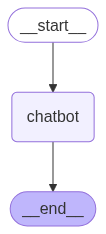

In [35]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [41]:
input={"messages":["What the weather in Gurugram,Haryana"]}

In [42]:
app.invoke(input)

{'messages': [HumanMessage(content='What the weather in Gurugram,Haryana', additional_kwargs={}, response_metadata={}, id='ab1dbb50-59dd-4c56-8585-b95b15a905dc'),
  AIMessage(content="The weather in Gurugram, Haryana is currently **hazy** with a temperature of around **35°C (95°F)**.\n\nIt feels warmer, closer to **37°C (99°F)**, due to the humidity.\n\nHere's a quick summary:\n*   **Conditions:** Hazy\n*   **Temperature:** 35°C (95°F)\n*   **Feels Like:** 37°C (99°F)\n*   **Humidity:** Around 50%\n*   **Wind:** Light breeze (e.g., 10-15 km/h from the West)\n*   **UV Index:** High\n\nNo rain is expected for the rest of today. The day will remain warm and hazy.\n\n**Please note:** Weather can change quickly, so for the most up-to-the-minute information, it's always best to check a reliable weather app or website like Google Weather, AccuWeather, or The Weather Channel.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason

In [43]:
for output in app.stream(input):
    for key,value in output.items():
        print(f"Output from {key} Node")
        print("_______")
        print(value)
        print("\n")

Output from chatbot Node
_______
{'messages': [AIMessage(content="The weather in Gurugram, Haryana is currently:\n\n*   **Temperature:** Around **38°C** (feels like 40°C)\n*   **Conditions:** **Hazy sunshine**\n*   **Humidity:** Approximately **40%**\n*   **Wind:** Light breeze from the west-northwest at around 10 km/h\n*   **UV Index:** 11 (Extreme)\n\n**Today's Forecast:**\n*   High: Around **42°C**\n*   Low: Around **30°C**\n\n**Advisory:** A **heatwave warning** is likely in effect. It's advisable to stay hydrated, avoid prolonged sun exposure, especially during peak afternoon hours, and take necessary precautions.\n\n*(Please note: Weather conditions can change, so for the most up-to-the-minute details, it's always best to check a live weather app or local forecast.)*", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--34c60215-c462-4df5-9

In [44]:
@tool
def search(query: str):
    """this is my custom tool."""
    if "sf" in query.lower() or "Gurugram" in query.lower():
        return "It's 60 degrees and foggy."
    return "It's 90 degrees and sunny."

In [45]:
search.invoke("what is a temprature in Gurugram?")

"It's 90 degrees and sunny."

In [53]:
search.invoke("what is a weather in india?")

"It's 90 degrees and sunny."

In [54]:
search

StructuredTool(name='search', description='this is my custom tool.', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x00000251094DF010>)

In [46]:
tools=[search]

In [47]:
tool_node=ToolNode(tools)

In [48]:
llm_with_tool=llm.bind_tools(tools)

In [49]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = llm_with_tool.invoke(messages)
    return {"messages": [response]}

In [50]:
response=call_model({"messages": ["hi how are you?"]})

In [51]:
response

{'messages': [AIMessage(content="I'm doing well, thank you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--d6c829d5-1b6d-467c-b54e-dabe0664cea1-0', usage_metadata={'input_tokens': 42, 'output_tokens': 16, 'total_tokens': 58, 'input_token_details': {'cache_read': 0}})]}

[AIMessage(content='I am doing well, thank you. How are you?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 941, 'total_tokens': 955, 'completion_time': 0.025454545, 'prompt_time': 0.030139486, 'queue_time': 0.0028640919999999986, 'total_time': 0.055594031}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-7176e5d9-307e-4644-93e2-99d358198179-0', usage_metadata={'input_tokens': 941, 'output_tokens': 14, 'total_tokens': 955})]

In [52]:
messages = response['messages']

In [53]:
last_message=messages[-1]

In [54]:
last_message.tool_calls

[]

In [55]:
response=call_model({"messages": ["what is a weather in India?"]})

In [56]:
response

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in India"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--3512fd0e-ad4c-42c1-a4f9-e759717500e9-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': 'b18925a5-ab6c-47ea-b901-a83f4eb37a44', 'type': 'tool_call'}], usage_metadata={'input_tokens': 44, 'output_tokens': 57, 'total_tokens': 101, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 42}})]}

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5q56', 'function': {'arguments': '{"query":"weather in India"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 943, 'total_tokens': 1025, 'completion_time': 0.149090909, 'prompt_time': 0.031104902, 'queue_time': 0.003129146000000003, 'total_time': 0.180195811}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-35d08bfe-0844-4902-8d36-71630335dd9e-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in India'}, 'id': 'call_5q56', 'type': 'tool_call'}], usage_metadata={'input_tokens': 943, 'output_tokens': 82, 'total_tokens': 1025})]

In [57]:
messages = response['messages']

In [58]:
last_message=messages[-1]

In [59]:
last_message.tool_calls

[{'name': 'search',
  'args': {'query': 'weather in India'},
  'id': 'b18925a5-ab6c-47ea-b901-a83f4eb37a44',
  'type': 'tool_call'}]

In [60]:
def router_function(state: MessagesState) -> Literal["tools", END]:
    #print(f"here is a state from should continue {state}")
    messages = state['messages']
    last_message = messages[-1]
    #print(f"here is a last message from should continue {last_message}")
    if last_message.tool_calls:
        return "tools"
    return END

In [61]:
# Define a new graph
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")

workflow.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

app = workflow.compile()

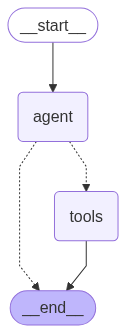

In [62]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [63]:
app.invoke({"messages": ["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='6839379f-6814-413f-9f2b-66211196c691'),
  AIMessage(content="I'm doing well, thank you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--163dbddf-ae99-4a35-b98f-72a2dc3a954d-0', usage_metadata={'input_tokens': 42, 'output_tokens': 16, 'total_tokens': 58, 'input_token_details': {'cache_read': 0}})]}

In [64]:
app.invoke({"messages": ["what is the weather in sf"]})

{'messages': [HumanMessage(content='what is the weather in sf', additional_kwargs={}, response_metadata={}, id='07f44655-6c04-412c-8864-89320dcfebd2'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--442e7dc3-6994-4ca1-bf11-735595afedb7-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': 'dcacaec4-20de-4322-8b34-efbe8f35248a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, 'output_tokens': 60, 'total_tokens': 103, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 45}}),
  ToolMessage(content="It's 60 degrees and foggy.", name='search', id='8bc7fcc7-e72e-40b0-8753-c9dbb0a6a137', tool_call_id='dcacaec4-20de-4322-8b34-efbe8f35248a')]}

In [65]:
workflow.add_edge("tools", 'agent')

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [66]:
app = workflow.compile()

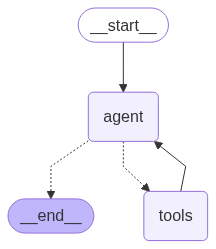

In [67]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [68]:
for output in app.stream({"messages": ["what is the weather in sf"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

here is output from agent
_______
{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'search', 'arguments': '{"query": "weather in sf"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--9774b466-65b6-4fe3-9a2b-3aa4d3259df1-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in sf'}, 'id': '4eb52963-d135-4ced-a514-db44cf01ecbf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 43, 'output_tokens': 105, 'total_tokens': 148, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 90}})]}


here is output from tools
_______
{'messages': [ToolMessage(content="It's 60 degrees and foggy.", name='search', id='7cffa30c-5ca5-4035-b13a-861623cf22a2', tool_call_id='4eb52963-d135-4ced-a514-db44cf01ecbf')]}


here is output from agent
_______
{'messages': [AIMessage(content='The weather in SF is 60 degrees 

In [69]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [70]:
# Define a new graph
workflow3 = StateGraph(MessagesState)

workflow3.add_node("agent", call_model)
workflow3.add_node("tools", tool_node)

workflow3.add_edge(START, "agent")

workflow3.add_conditional_edges("agent",router_function,{"tools": "tools", END: END})

workflow3.add_edge("tools", 'agent')

In [71]:
app3 = workflow3.compile(checkpointer = memory)

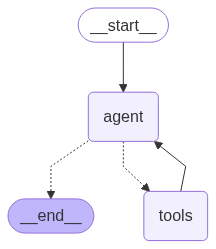

In [72]:
from IPython.display import Image, display

try:
    display(Image(app3.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [74]:
config = {"configurable": {"thread_id": "1"}}

In [76]:
events = app3.stream(
    {"messages": ["Hi there! My name is Shivam."]}, config, stream_mode="values"
)

In [77]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Shivam.
================================== Ai Message ==================================

Hello Shivam, it's nice to meet you! How can I help you today?


In [78]:
events = app3.stream(
    {"messages": ["can you tell me what was my name?"]}, config, stream_mode="values"
)

In [79]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

can you tell me what was my name?
================================== Ai Message ==================================

Your name is Shivam.


In [80]:
memory.get(config)

{'v': 4,
 'ts': '2025-08-21T07:05:36.962868+00:00',
 'id': '1f07e5d3-d0a4-6c0f-8004-39b9bc64d678',
 'channel_versions': {'__start__': '00000000000000000000000000000005.0.18260143265785034',
  'messages': '00000000000000000000000000000006.0.8664978185093213',
  'branch:to:agent': '00000000000000000000000000000006.0.8664978185093213'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000004.0.4469390647332896'},
  'agent': {'branch:to:agent': '00000000000000000000000000000005.0.18260143265785034'}},
 'updated_channels': ['messages'],
 'channel_values': {'messages': [HumanMessage(content='Hi there! My name is Shivam.', additional_kwargs={}, response_metadata={}, id='6f82afeb-190d-416a-9f9d-486d3ebfe41d'),
   AIMessage(content="Hello Shivam, it's nice to meet you! How can I help you today?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flas